In [438]:
from model.networks_bf import get_all_devices_combined
from model.services_bf import get_all_services
import itertools
import numpy as np
import pandas as pd

In [439]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def preprocess_data(R, S, X, PI, PM, SAL, SIPS, SL):
    # Initialize the scalers
    scaler = MinMaxScaler()
    one_hot_encoder = OneHotEncoder()

    # Normalize the multi-dimensional arrays
    R_norm = scaler.fit_transform(R.flatten().reshape(-1, 1)).reshape(R.shape)
    S_norm = scaler.fit_transform(S.flatten().reshape(-1, 1)).reshape(S.shape)
    X_norm = scaler.fit_transform(X.flatten().reshape(-1, 1)).reshape(X.shape)
    PI_norm = scaler.fit_transform(PI.flatten().reshape(-1, 1)).reshape(PI.shape)
    PM_norm = scaler.fit_transform(PM.flatten().reshape(-1, 1)).reshape(PM.shape)

    # Normalize the one-dimensional arrays
    SAL_norm = scaler.fit_transform(np.array(SAL).reshape(-1, 1)).flatten()
    SIPS_norm = scaler.fit_transform(np.array(SIPS).reshape(-1, 1)).flatten()

    # One-hot encode the categorical array SL
    SL_encoded = one_hot_encoder.fit_transform(np.array(SL).reshape(-1, 1)).toarray()

    # Flatten the arrays and concatenate
    flattened_data = np.concatenate((R_norm.flatten(), S_norm.flatten(), X_norm.flatten(),
                                     PI_norm.flatten(), PM_norm.flatten(), SAL_norm, 
                                     SIPS_norm, SL_encoded.flatten()))

    return flattened_data

In [441]:
# Get the real output values
file_path = 'results/results_mini_bf.csv'
bf_data = pd.read_csv(file_path)

bf_data['placement_physical'] = bf_data['placement_physical'].apply(lambda x: eval(x))
bf_data['placement_vm'] = bf_data['placement_vm'].apply(lambda x: eval(x))

pms = bf_data['placement_physical']
vms = bf_data['placement_vm']

merged = [np.concatenate((pm, vm)) for pm, vm in zip(pms, vms)]

max_output_size = max(len(array) for array in merged)  # Find the size of the largest array
padded_outputs = [np.pad(array, (0, max_output_size - len(array)), mode='constant', constant_values=-1) for array in merged]

outputs_array = np.array(padded_outputs)

In [442]:
inputs = []
for c in range(1, 101):
    
    print(f"Processing config-{c}....")
    
    physical_machines = get_all_devices_combined(f"config-{c}")
    services = get_all_services(f"config-{c}")
    
    # Define the problem-specific parameters
    n = len(physical_machines)  # Number of physical machines
    s = len(services)  # Number of services
    
    vm_list = []
    
    for p in range(len(physical_machines)):
        for v in range(len(physical_machines[p].guest_machines)):
            vm_list.append([p, v])
    
    # Calculate all permutations of vm_list with s places (with repetition)
    permutations = itertools.product(vm_list, repeat=s)
    
    # Variable number of virtual machines for each physical machine
    max_v = max(map(lambda machine: len(machine.guest_machines), physical_machines))
    
    ################ Physical and virtual machine configurations ##################
    
    # Initialization
    R = np.empty(shape=(n, max_v))  # Request network delay of the machine
    R.fill(999999) # Initialize with very large value
    S = np.empty(shape=(n, max_v))  # Response network delay of the machine
    S.fill(999999) # Initialize with very large value
    X = np.empty(shape=(n, max_v))  # Maximum IPS possible
    X.fill(1) # Initialize with 1
    
    PI = np.empty(shape=(n, max_v))  # Power consumption in idle
    PI.fill(999) # Initialize with very large value
    PM = np.empty(shape=(n, max_v))  # Maximum power consumption
    PM.fill(999) # Initialize with very large value
    
    # Fill in with the actual numbers
    for i in range(len(physical_machines)):
        for j in range(len(physical_machines[i].guest_machines)):
            R[i][j] = physical_machines[i].guest_machines[j].net_delay_request
            S[i][j] = physical_machines[i].guest_machines[j].net_delay_response
            X[i][j] = physical_machines[i].guest_machines[j].max_instructions_per_second
            PI[i][j] = physical_machines[i].guest_machines[j].idle_cpu_utilization
            PM[i][j] = physical_machines[i].guest_machines[j].max_cpu_utilization
    
    ################ Service configurations ###################
    
    # Acceptable latencies for services
    SAL = [service.acceptable_latency for service in services]
    # Initialize IPS values for services (replace with actual data)
    SIPS = [service.average_instructions_per_second for service in services]
    # Layers considered for service
    SL = [service.layer for service in services]
    
    ################# Preprocess the data ####################
    input_data = preprocess_data(R, S, X, PI, PM, SAL, SIPS, SL)
    inputs.append(input_data)

Processing config-1....
Processing config-2....
Processing config-3....
Processing config-4....
Processing config-5....
Processing config-6....
Processing config-7....
Processing config-8....
Processing config-9....
Processing config-10....
Processing config-11....
Processing config-12....
Processing config-13....
Processing config-14....
Processing config-15....
Processing config-16....
Processing config-17....
Processing config-18....
Processing config-19....
Processing config-20....
Processing config-21....
Processing config-22....
Processing config-23....
Processing config-24....
Processing config-25....
Processing config-26....
Processing config-27....
Processing config-28....
Processing config-29....
Processing config-30....
Processing config-31....
Processing config-32....
Processing config-33....
Processing config-34....
Processing config-35....
Processing config-36....
Processing config-37....
Processing config-38....
Processing config-39....
Processing config-40....
Processin

In [443]:
max_input_size = max(len(array) for array in inputs)  # Find the size of the largest array
padded_inputs = [np.pad(array, (0, max_input_size - len(array)), mode='constant', constant_values=-1) for array in inputs]

inputs_array = np.array(padded_inputs)

In [444]:
def scale_and_round(tensor):
    # Replace negative values with 0
    tensor_with_no_negatives = tf.maximum(tensor, 0)

    # Scale positive values to have min 0 and max 2
    scaled = 2 * (tensor_with_no_negatives - tf.reduce_min(tensor_with_no_negatives)) / \
                       (tf.reduce_max(tensor_with_no_negatives) - tf.reduce_min(tensor_with_no_negatives))

    # Round the scaled positive values
    rounded = tf.cast(tf.round(scaled), tf.int32)

    return rounded

In [445]:
# Custom loss function
def custom_loss(yt, yp):
    # Batch size is 1
    yt = yt[0]
    yp = yp[0]
    length = tf.size(yt) // 2
    indices = tf.where(tf.equal(yt, -1))
    if tf.shape(indices)[0] > 0:
        length = tf.cast(indices[0][0] // 2, tf.int32)
        
    actual_pms = yt[:length]
    actual_vms = yt[length:length*2]
    predicted_pms = yp[:length]
    predicted_vms = yp[length:length*2]

    # Check if PMs match and then check VMs
    mse = keras.losses.MeanSquaredError()
    pm_mse = mse(actual_pms, predicted_pms)
    vm_mse = mse(actual_vms, predicted_vms)

    return (2 * pm_mse) + vm_mse   

# Custom accuracy metric
def custom_accuracy(yt, yp):
    # Batch size is 1
    yt = yt[0]
    yp = yp[0]
    length = tf.size(yt) // 2
    indices = tf.where(tf.equal(yt, -1))
    if tf.shape(indices)[0] > 0:
        length = tf.cast(indices[0][0] // 2, tf.int32)
        
    actual_pms = yt[:length]
    actual_vms = yt[length:length*2]
    predicted_pms = yp[:length]
    predicted_vms = yp[length:length*2]

    # Check if PMs match and then check VMs
    mse = keras.losses.MeanSquaredError()
    pm_mse = mse(actual_pms, predicted_pms)
    vm_mse = mse(actual_vms, predicted_vms)
    
    length = tf.cast(length, tf.float32)
    
    return (length - ((2 * pm_mse) + vm_mse)) / length

In [446]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Split the data into training and test sets (e.g., 80% training, 20% test)
train_ratio = 0.8
train_size = int(len(inputs_array) * train_ratio)
X_train, X_test = inputs_array[:train_size], inputs_array[train_size:]
y_train, y_test = outputs_array[:train_size], outputs_array[train_size:]

# Define the neural network model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer='l1'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='linear'))  # Output layer with a number of neurons equal to the output size

model.compile(optimizer='adam', loss=custom_loss, metrics=[custom_accuracy])
# model.compile(optimizer='sgd', loss='mse', metrics=['acc'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test))

# Evaluate the model's performance
model.evaluate(X_test, y_test)

Epoch 1/100
80/80 [==============================] - 1s 3ms/step - loss: 16.0770 - custom_accuracy: 0.6980 - val_loss: 12.9500 - val_custom_accuracy: 0.8012
Epoch 2/100
80/80 [==============================] - 0s 1ms/step - loss: 11.6106 - custom_accuracy: 0.7641 - val_loss: 9.9962 - val_custom_accuracy: 0.8192
Epoch 3/100
80/80 [==============================] - 0s 1ms/step - loss: 9.0599 - custom_accuracy: 0.7821 - val_loss: 7.8170 - val_custom_accuracy: 0.8330
Epoch 4/100
80/80 [==============================] - 0s 1ms/step - loss: 7.0834 - custom_accuracy: 0.7872 - val_loss: 5.9555 - val_custom_accuracy: 0.8391
Epoch 5/100
80/80 [==============================] - 0s 1ms/step - loss: 5.4108 - custom_accuracy: 0.8059 - val_loss: 4.6364 - val_custom_accuracy: 0.8477
Epoch 6/100
80/80 [==============================] - 0s 1ms/step - loss: 4.2623 - custom_accuracy: 0.8072 - val_loss: 3.5557 - val_custom_accuracy: 0.8548
Epoch 7/100
80/80 [==============================] - 0s 2ms/step - 

[0.9285241961479187, 0.8842596411705017]

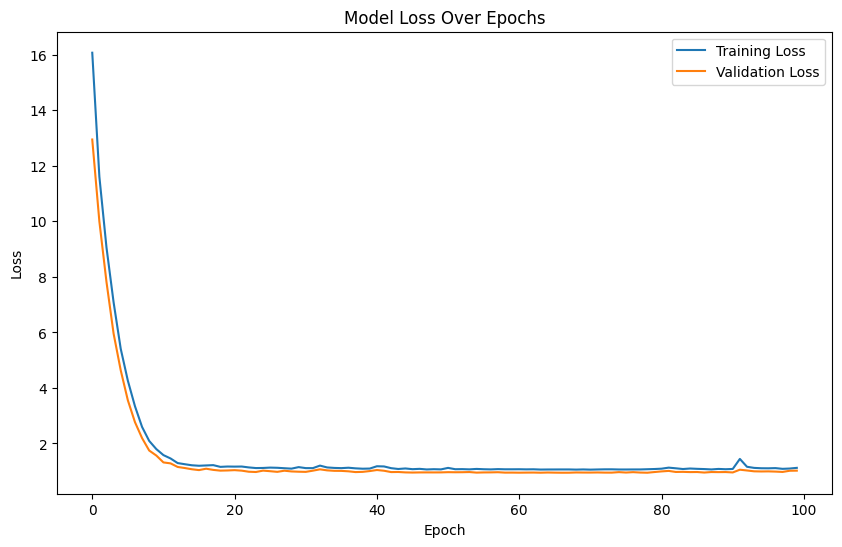

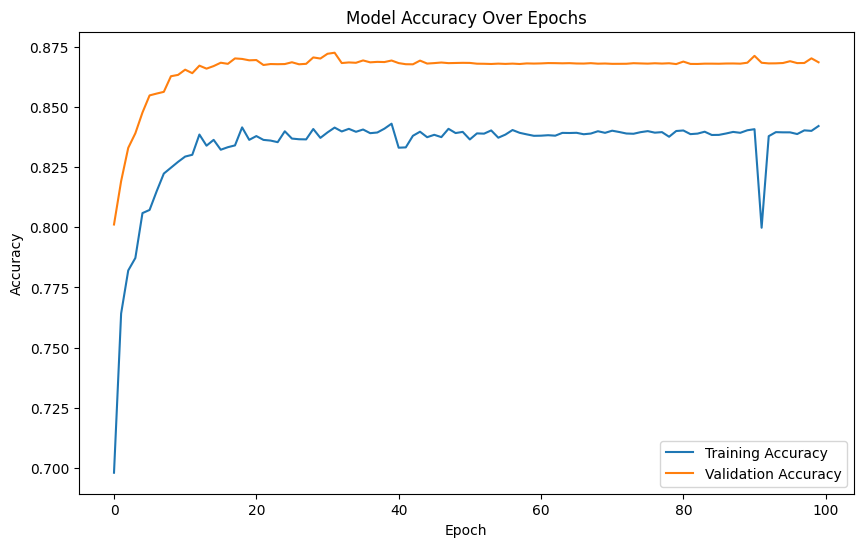

In [447]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
# plt.plot(history.history['acc'], label='Training Accuracy')
# plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [448]:
# Predict on the test dataset
predictions = model.predict(inputs_array)
predictions

4/4 [==============================] - 0s 980us/step


array([[0.5604899 , 0.5342879 , 0.45153213, ..., 0.39966455, 0.20199181,
        0.26391774],
       [0.5603221 , 0.53413874, 0.45139796, ..., 0.39953548, 0.20193455,
        0.26380447],
       [0.5599946 , 0.53384745, 0.4511361 , ..., 0.39928356, 0.20182277,
        0.2635834 ],
       ...,
       [0.55996186, 0.5338183 , 0.45110995, ..., 0.39925838, 0.2018116 ,
        0.26356128],
       [0.5764036 , 0.55297846, 0.46542266, ..., 0.40305448, 0.19842674,
        0.25916827],
       [0.56085   , 0.53460824, 0.45182002, ..., 0.39994153, 0.2021147 ,
        0.26416084]], dtype=float32)

In [449]:
columns = ['config', 'physical_machines', 'services', 'generations', 'alpha', 'beta', 'latency', 'energy', 'placement_physical', 'placement_vm', 'is_perfect']
results_headers = pd.DataFrame(columns=columns)
results_headers.to_csv('results/results_mini_ann.csv', mode='a', index=False)
results_df = pd.DataFrame()

for i in range(len(predictions)):
    c = i + 1
    
    print(f"Processing config-{c}....")
    
    physical_machines = get_all_devices_combined(f"config-{c}")
    services = get_all_services(f"config-{c}")
    
    # Define the problem-specific parameters
    n = len(physical_machines)  # Number of physical machines
    s = len(services)  # Number of services
    
    pm_placement = predictions[i][:s]
    # pm_placement = (n - 1) * (pm_placement - pm_placement.min()) / (pm_placement.max() - pm_placement.min())
    pm_placement = np.rint(pm_placement).astype(int)
    
    # Variable number of virtual machines for each physical machine
    max_v = max(map(lambda machine: len(machine.guest_machines), physical_machines))
    
    vm_placement = predictions[i][s:2*s]
    # vm_placement = (max_v - 1) * (vm_placement - vm_placement.min()) / (vm_placement.max() - vm_placement.min())
    vm_placement = np.rint(vm_placement).astype(int)
    
    # Initialization
    R = np.empty(shape=(n, max_v))  # Request network delay of the machine
    R.fill(999999) # Initialize with very large value
    S = np.empty(shape=(n, max_v))  # Response network delay of the machine
    S.fill(999999) # Initialize with very large value
    X = np.empty(shape=(n, max_v))  # Maximum IPS possible
    X.fill(1) # Initialize with 1
    
    PI = np.empty(shape=(n, max_v))  # Power consumption in idle
    PI.fill(999) # Initialize with very large value
    PM = np.empty(shape=(n, max_v))  # Maximum power consumption
    PM.fill(999) # Initialize with very large value
    
    # Fill in with the actual numbers
    for i in range(len(physical_machines)):
        for j in range(len(physical_machines[i].guest_machines)):
            R[i][j] = physical_machines[i].guest_machines[j].net_delay_request
            S[i][j] = physical_machines[i].guest_machines[j].net_delay_response
            X[i][j] = physical_machines[i].guest_machines[j].max_instructions_per_second
            PI[i][j] = physical_machines[i].guest_machines[j].idle_cpu_utilization
            PM[i][j] = physical_machines[i].guest_machines[j].max_cpu_utilization
    
    ################ Service configurations ###################
    
    # Acceptable latencies for services
    SAL = [service.acceptable_latency for service in services]
    # Initialize IPS values for services (replace with actual data)
    SIPS = [service.average_instructions_per_second for service in services]
    # Layers considered for service
    SL = [service.layer for service in services]
    
    
    I = np.empty(shape=(n, max_v))  # IPS currently executed
    I.fill(0) # Initialize with 0
    # Calculate energy consumption based on the parameters
    E = PI + (PM - PI) * (I / X)
    
    
    # Compensate for invalid vm numbers generated by ANN. Set the wrong value to 0.
    for j in range(s):
        p = pm_placement[j]
        if len(physical_machines[p].guest_machines) <= vm_placement[j]:
            vm_placement[j] = 0

    total_latency = 0
    total_energy = 0
    
    is_perfect = [True] * s # To check if the permutation is perfect
    
    for p in range(len(physical_machines)):
        for v in range(len(physical_machines[p].guest_machines)):
            total_energy += E[p][v] # Calculate the initial energy consumption
    
    for j in range(s):
        p = pm_placement[j]
        v = vm_placement[j]
        
        vm = physical_machines[p].guest_machines[v]
        latency = R[p][v] + (SIPS[i] * 1000 / X[p][v]) + S[p][v]
        
        # If this configuration is not perfect, mark it as not perfect
        if latency > SAL[i] or (SL[i] is not None and SL[i] != vm.layer):
            is_perfect[i] = False
            
        total_latency += latency # Calculate latency again for new placement
        I[p][v] = I[p][v] + SIPS[i] # Update the current instructions per second
        total_energy += (PI[p][v] + (PM[p][v] - PI[p][v]) * (I[p][v] / X[p][v])) # Calculate energy consumption
    
    results_df = results_df._append({'config': f'config-{c}',
                                     'physical_machines': n,
                                     'services': s,
                                     'generations': 0,
                                     'alpha': 0.5,
                                     'beta': 0.5,
                                     'latency': total_latency,
                                     'energy': total_energy,
                                     'placement_physical': pm_placement,
                                     'placement_vm': vm_placement,
                                     'is_perfect': is_perfect}, ignore_index=True)
results_df.to_csv('results/results_mini_ann.csv', mode='a', index=False, header=False)

Processing config-1....
Processing config-2....
Processing config-3....
Processing config-4....
Processing config-5....
Processing config-6....
Processing config-7....
Processing config-8....
Processing config-9....
Processing config-10....
Processing config-11....
Processing config-12....
Processing config-13....
Processing config-14....
Processing config-15....
Processing config-16....
Processing config-17....
Processing config-18....
Processing config-19....
Processing config-20....
Processing config-21....
Processing config-22....
Processing config-23....
Processing config-24....
Processing config-25....
Processing config-26....
Processing config-27....
Processing config-28....
Processing config-29....
Processing config-30....
Processing config-31....
Processing config-32....
Processing config-33....
Processing config-34....
Processing config-35....
Processing config-36....
Processing config-37....
Processing config-38....
Processing config-39....
Processing config-40....
Processin